In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import root_mean_squared_error

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [2]:
data = pd.read_csv("data_encoded.csv")

In [3]:
y = data.Adopted

In [4]:
x = data.drop(columns=["Adopted"])

In [5]:
import torch
 
X_nn = torch.tensor(x.values.astype(np.float32), dtype=torch.float32)
y_nn = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [6]:
X_nn.shape

torch.Size([12073, 319])

In [7]:
import torch.nn as nn

class AdoptionModel(nn.Module):
    def __init__(self,dims):
        super().__init__()
        self.hidden = nn.Linear(dims, dims)
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(dims, dims)
        self.hidden3 = nn.Linear(dims, dims//2)
        self.hidden4 = nn.Linear(dims//2, dims//4)
        self.hidden5 = nn.Linear(dims//4, dims//8)
        self.output = nn.Linear(dims//8, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.dropout(self.relu(self.hidden(x)))
        x = self.dropout(self.relu(self.hidden2(x)))
        x = self.dropout(self.relu(self.hidden3(x)))
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x))
        x = self.sigmoid(self.output(x))
        
        return x

In [8]:
model = AdoptionModel(X_nn.shape[1])

In [9]:
x_train, x_test, y_train, y_test= train_test_split(X_nn, y_nn, shuffle=True, test_size=.2)

In [10]:
import torch.optim as optim
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import warnings
import shutil

train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=128)

test_data = []
for i in range(len(x_test)):
   test_data.append([x_test[i], y_test[i]])

testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=128)

dataloaders={}
dataloaders['train']=trainloader
dataloaders['val']=testloader

dataset_sizes={}
dataset_sizes['train']=x_train.shape[0]
dataset_sizes['val']=x_test.shape[0]
 
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, start_epoch=0, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = [0.0 for i in range(0, num_epochs)] #start_epoch
    val_loss = [0.0 for i in range(0, num_epochs)]
    train_acc = [0.0 for i in range(0, num_epochs)]
    val_acc = [0.0 for i in range(0, num_epochs)]

    for epoch in range(start_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            end = time.time()
            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                # zero the parameter gradients, clear the gradients of all optimized variables
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) 
                    
                    if type(outputs) is tuple: #model may output multiple tensors as tuple
                        outputs, _ = outputs

                    # calculate the batch loss
                    loss = criterion(outputs, labels)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # backward pass: compute gradient of the loss with respect to model parameters
                        loss.backward()
                        # perform a single optimization step (parameter update)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)#batch size
                for i in range(len(outputs)):
                    if outputs[i]>=.5:
                        if labels[i]==1:
                            running_corrects+=1
                    else:
                        if labels[i]==0:
                            running_corrects+=1
        
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plt.figure(figsize=(10,5))
    plt.title("Loss graph")
    plt.plot(range(0,num_epochs),train_loss)
    plt.plot(range(0,num_epochs),val_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(['train','validation'])
    plt.show()

    plt.title("Accuracy graph")
    plt.plot(range(0,num_epochs),train_acc)
    plt.plot(range(0,num_epochs),val_acc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train','validation'])
    plt.show()
    
    return model


D:\conda\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Epoch 0/99
----------
train Loss: 0.6767 Acc: 0.6209
val Loss: 0.6595 Acc: 0.6282
Epoch 1/99
----------
train Loss: 0.6628 Acc: 0.6328
val Loss: 0.6570 Acc: 0.6282
Epoch 2/99
----------
train Loss: 0.6553 Acc: 0.6337
val Loss: 0.6489 Acc: 0.6282
Epoch 3/99
----------
train Loss: 0.6279 Acc: 0.6336
val Loss: 0.6032 Acc: 0.6282
Epoch 4/99
----------
train Loss: 0.6012 Acc: 0.6340
val Loss: 0.5838 Acc: 0.6282
Epoch 5/99
----------
train Loss: 0.5770 Acc: 0.6343
val Loss: 0.5369 Acc: 0.6282
Epoch 6/99
----------
train Loss: 0.5653 Acc: 0.6343
val Loss: 0.5799 Acc: 0.6282
Epoch 7/99
----------
train Loss: 0.5537 Acc: 0.6530
val Loss: 0.5569 Acc: 0.7172
Epoch 8/99
----------
train Loss: 0.5314 Acc: 0.7036
val Loss: 0.5212 Acc: 0.7466
Epoch 9/99
----------
train Loss: 0.5205 Acc: 0.7167
val Loss: 0.4914 Acc: 0.7366
Epoch 10/99
----------
train Loss: 0.5116 Acc: 0.7201
val Loss: 0.5032 Acc: 0.7267
Epoch 11/99
----------
train Loss: 0.5214 Acc: 0.7117
val Loss: 0.5101 Acc: 0.7259
Epoch 12/99
--

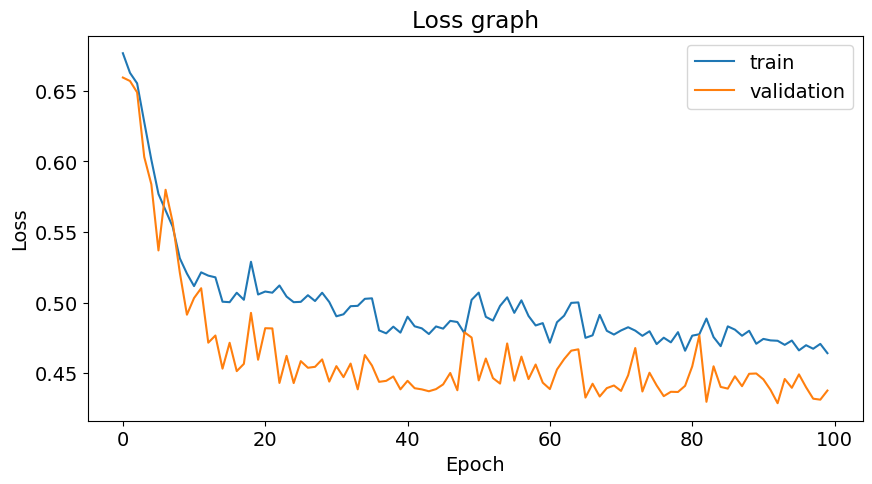

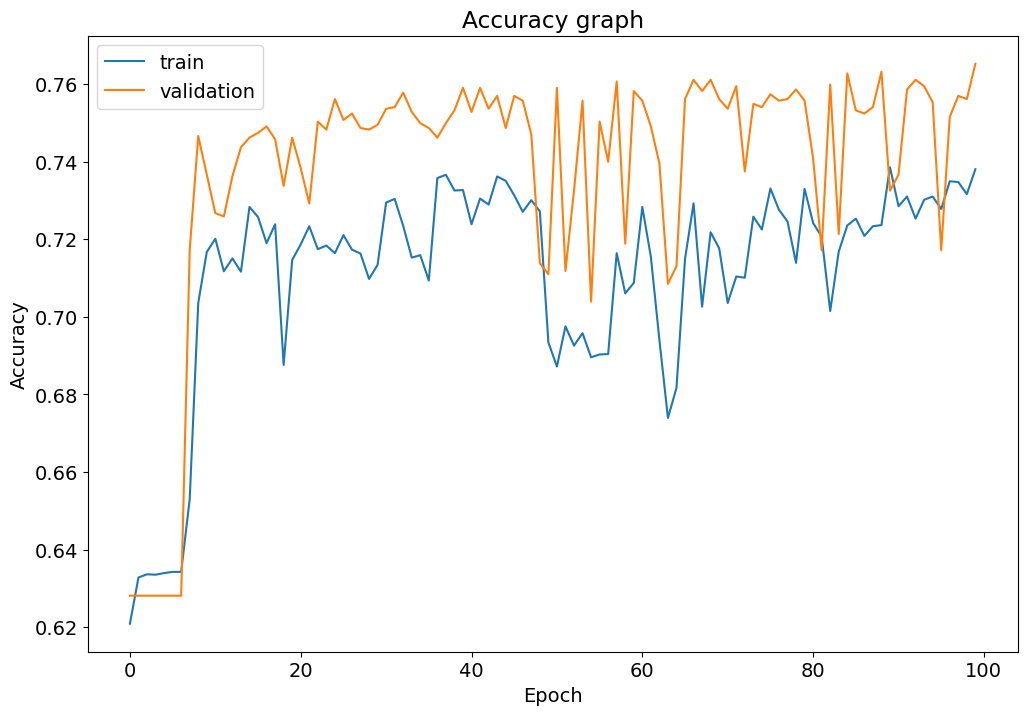

AdoptionModel(
  (hidden): Linear(in_features=319, out_features=319, bias=True)
  (relu): ReLU()
  (hidden2): Linear(in_features=319, out_features=319, bias=True)
  (hidden3): Linear(in_features=319, out_features=159, bias=True)
  (hidden4): Linear(in_features=159, out_features=79, bias=True)
  (hidden5): Linear(in_features=79, out_features=39, bias=True)
  (output): Linear(in_features=39, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

In [12]:
train_model(model, dataloaders, dataset_sizes, loss_fn, optimizer, start_epoch=0, num_epochs=100)